In [1]:
# SEM GPU é muito mais rápido e dá menos erro
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import time


## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed
gdrive = "."

log_file = open("output-unet.log","w")

def print_log(*args):
    line = " ".join([str(a) for a in args])
    log_file.write(line+"\n")
    print(line)

print_log(tf.__version__)
print_log(tf.keras.__version__)




2.10.1
2.10.0


In [2]:
#data generator class
class DataGen(keras.utils.Sequence):
    def __init__(self, train_ids, train_path, batch_size=3, image_size=256):
        self.ids = train_ids;
        self.path = train_path;
        self.batch_size = batch_size;
        self.image_size = image_size;
        self.on_epoch_end();
        
    def __load__(self, id_name):
        #defining path for the training data set
        
        id_name_mask = id_name.replace(".JPG",".png").replace(".jpg",".png")
        

        image_path = os.path.join(self.path, "images", id_name);
        mask_path = os.path.join(self.path, "masks", id_name_mask); #mascaras estao em .png
        
        # reading the image from dataset
        ## Reading Image
        image = cv2.imread(image_path, 1); #reading image to image vaiable
        image = cv2.resize(image, (self.image_size, self.image_size));
        mask = cv2.imread(mask_path, 0); #mask image of same size with all zeros
        mask = cv2.resize(mask, (self.image_size ,self.image_size));
        mask = np.expand_dims(mask, axis=-1);
        #image normalisation
        image = image / 255.0;
        mask = mask / 255.0;
        
        return image, mask;
    
    def __getitem__(self, index): #index : batch no.
        
        if(index+1)*self.batch_size > len(self.ids): # redining last batch size
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size] #list of 10 image ids
        
        image = [] #collection of 10 images
        mask  = [] #collection of 10 masks
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name);
            image.append(_img);
            mask.append(_mask);
            
        image = np.array(image);
        mask  = np.array(mask);
        
        return image, mask; #return array of 10 images and 10 masks
    
    #for printing the statistics of the function
    def on_epoch_end(self):
        print_log("epoch completed");
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));#length of the epoch as length of generation DataGen obj

In [3]:

#hyperparameter
image_size = 256;

#ATENCAO 512 trava o PC


#train_path = gdrive + "/malaria_broadinstitute_relabeled-unet/"; #address of the dataset
#train_path = "../pyAnnotation/malaria_broadinstitute_relabeled-11-masks/"; #address of the dataset
train_path = gdrive + "/data-1024x1024-border/"; #address of the dataset
#train_path = gdrive + "/data-1024x1024/"; #address of the dataset
#epochs = 400; #number of time we need to train dataset
batch_size = 10; #tarining batch size

#train path
train_ids = os.listdir(train_path + "/images")
#Validation Data Size
val_data_size = 1; #size of set of images used for the validation 

valid_ids = train_ids[:val_data_size]; # list of image ids used for validation of result 0 to 9
train_ids = train_ids[val_data_size:]; #list of image ids used for training dataset
print_log("training_size: ", len(train_ids), "validation_size: ", len(valid_ids))

#making generator object
gen = DataGen(train_ids, train_path, batch_size, image_size);
print_log("total epoch: ", len(gen))

training_size:  19 validation_size:  1
epoch completed
total epoch:  2


shape of the batch (10, 256, 256, 3) (10, 256, 256, 1)
Number of images in the batch:  10


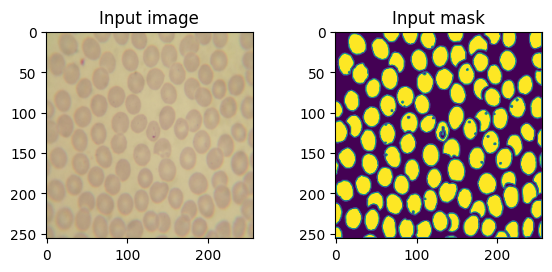

In [4]:
#Analysing sample of the dataset from data generator


#getting image_set data from dataset
x, y = gen.__getitem__(0); # self = gen and index = 0 each item is a set of 8 images
print_log("shape of the batch", x.shape, y.shape);
print_log("Number of images in the batch: ", len(x));

#display of the sample of the data zeroth image

fig = plt.figure();
fig.subplots_adjust(hspace=0.4, wspace=0.4); #reserving height above plot and space between plots
ax = fig.add_subplot(1, 2, 1); #figure of 1 row 2 columns and 1st image
x1 = (x[2]*255).astype(np.uint8);
x1 = cv2.cvtColor(x1, cv2.COLOR_BGR2RGB);
ax.imshow(x1);
plt.title("Input image");

ax = fig.add_subplot(1, 2, 2); #2nd image plot
ax.imshow(np.reshape(y[2], (image_size, image_size)));
plt.title("Input mask");

In [5]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [6]:
def UNet(size):
    if (size == 128):
        return UNet128()
    elif (size == 256):
        return UNet256()
    elif (size == 512):
        return UNet512()
    
#unet model
def UNet512():
    f = [16, 32, 64, 128, 256, 512, 768]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0], kernel_size=(15,15)) #pooling layer downsmaples 128 image to 256
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 128
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 64
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 32
    c5, p5 = down_block(p4, f[4]) #pooling layer downsmaples 128 image to 16
    c6, p6 = down_block(p5, f[5]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p6, f[6])
    
    u1 = up_block(bn, c6, f[5]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c5, f[4]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c4, f[3]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c3, f[2]) #upsampling layer upsmaples 8 image to 128
    u5 = up_block(u4, c2, f[1]) #upsampling layer upsmaples 8 image to 256
    u6 = up_block(u5, c1, f[0], kernel_size=(15,15)) #upsampling layer upsmaples 8 image to 512
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u6)
    model = keras.models.Model(inputs, outputs)
    return model

def UNet256():
    f = [16, 32, 64, 128, 256, 512]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128 image to 128
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 64
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 32
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 16
    c5, p5 = down_block(p4, f[4]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p5, f[5])
    
    u1 = up_block(bn, c5, f[4]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c4, f[3]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c3, f[2]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c2, f[1]) #upsampling layer upsmaples 8 image to 128
    u5 = up_block(u4, c1, f[0]) #upsampling layer upsmaples 8 image to 256
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u5)
    model = keras.models.Model(inputs, outputs)
    return model


def UNet128():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128 image to 64
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 32
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 16
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c3, f[2]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c2, f[1]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c1, f[0]) #upsampling layer upsmaples 8 image to 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

def impHistoria(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.title('train loss'); plt.ylabel('MSE loss'); plt.xlabel('epoch')
    plt.legend(['train loss'], loc='upper left')
    plt.show()
    plt.plot(history.history['acc'])
    plt.title('train accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch')
    plt.legend(['train accuracy'], loc='upper left')
    plt.show()

In [7]:
model = UNet(image_size)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 up_sampling2d_4 (UpSampling2D)  (None, 256, 256, 32  0          ['conv2d_19[0][0]']              
                                )                                                                 
                                                                                                  
 concatenate_4 (Concatenate)    (None, 256, 256, 48  0           ['up_sampling2d_4[0][0]',        
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 16  6928        ['concatenate_4[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_21

In [8]:
batch_size = 10
save_period = 50
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size);
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size);
print_log("total training batches: ", len(train_gen));
print_log("total validaton batches: ", len(valid_gen));
train_steps = len(train_ids)//batch_size;
valid_steps = len(valid_ids)//batch_size;
print_log("image_size:", image_size)
print_log("save_period:", save_period)
epochs = 300
print_log(epochs)
versao = 1

_fileName = gdrive + "/cells-s%d-e%d-v%d-tf241-comborda.h5"
filename = _fileName % (image_size, epochs, versao)

print_log("filename:",filename)

epoch completed
epoch completed
total training batches:  2
total validaton batches:  1
image_size: 256
save_period: 50
1000
filename: ./cells-s256-e1000-v1-tf241-comborda.h5


Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 0.6918 - acc: 0.4197
epoch completed
Epoch 2/1000
1/1 [==============================] - 2s 2s/step - loss: 0.6917 - acc: 0.3587
epoch completed
Epoch 3/1000
1/1 [==============================] - 2s 2s/step - loss: 0.6913 - acc: 0.3605
epoch completed
Epoch 4/1000
1/1 [==============================] - 0s 279ms/step - loss: 0.6754 - acc: 0.6069
epoch completed
Epoch 5/1000
1/1 [==============================] - 0s 289ms/step - loss: 0.6856 - acc: 0.3633
epoch completed
Epoch 6/1000
1/1 [==============================] - 0s 292ms/step - loss: 0.6916 - acc: 0.3747
epoch completed
Epoch 7/1000
1/1 [==============================] - 0s 285ms/step - loss: 0.6853 - acc: 0.3636
epoch completed
Epoch 8/1000
1/1 [==============================] - 0s 287ms/step - loss: 0.6999 - acc: 0.3478
epoch completed
Epoch 9/1000
1/1 [==============================] - 0s 284ms/step - loss: 0.6881 - acc: 0.3636
epoch completed
Epoch 10/1

epoch completed
Epoch 42/1000
1/1 [==============================] - 0s 291ms/step - loss: 0.6531 - acc: 0.6069
epoch completed
Epoch 43/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.6785 - acc: 0.3633
epoch completed
Epoch 44/1000
1/1 [==============================] - 0s 294ms/step - loss: 0.6857 - acc: 0.3747
epoch completed
Epoch 45/1000
1/1 [==============================] - 0s 288ms/step - loss: 0.6338 - acc: 0.5439
epoch completed
Epoch 46/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.6745 - acc: 0.3636
epoch completed
Epoch 47/1000
1/1 [==============================] - 0s 286ms/step - loss: 0.6961 - acc: 0.3633
epoch completed
Epoch 48/1000
1/1 [==============================] - 0s 288ms/step - loss: 0.6719 - acc: 0.4209
epoch completed
Epoch 49/1000
1/1 [==============================] - 0s 285ms/step - loss: 0.6736 - acc: 0.3548
epoch completed
Epoch 50/1000

Epoch 50: saving model to unet-checkpoint.h5
1/1 [=======================

1/1 [==============================] - 0s 285ms/step - loss: 0.5996 - acc: 0.6073
epoch completed
Epoch 83/1000
1/1 [==============================] - 0s 285ms/step - loss: 0.5932 - acc: 0.6673
epoch completed
Epoch 84/1000
1/1 [==============================] - 0s 283ms/step - loss: 0.5815 - acc: 0.5444
epoch completed
Epoch 85/1000
1/1 [==============================] - 0s 286ms/step - loss: 0.5875 - acc: 0.5256
epoch completed
Epoch 86/1000
1/1 [==============================] - 0s 285ms/step - loss: 0.5428 - acc: 0.6735
epoch completed
Epoch 87/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.4726 - acc: 0.7433
epoch completed
Epoch 88/1000
1/1 [==============================] - 0s 282ms/step - loss: 0.5445 - acc: 0.5909
epoch completed
Epoch 89/1000
1/1 [==============================] - 0s 293ms/step - loss: 0.6227 - acc: 0.5341
epoch completed
Epoch 90/1000
1/1 [==============================] - 0s 298ms/step - loss: 0.4796 - acc: 0.6781
epoch completed
Epoch 

1/1 [==============================] - 0s 356ms/step - loss: 0.8567 - acc: 0.4763
epoch completed
Epoch 123/1000
1/1 [==============================] - 0s 346ms/step - loss: 0.4635 - acc: 0.6211
epoch completed
Epoch 124/1000
1/1 [==============================] - 0s 341ms/step - loss: 0.4913 - acc: 0.6829
epoch completed
Epoch 125/1000
1/1 [==============================] - 0s 305ms/step - loss: 0.5652 - acc: 0.6568
epoch completed
Epoch 126/1000
1/1 [==============================] - 0s 309ms/step - loss: 0.6055 - acc: 0.5828
epoch completed
Epoch 127/1000
1/1 [==============================] - 0s 298ms/step - loss: 0.5874 - acc: 0.6174
epoch completed
Epoch 128/1000
1/1 [==============================] - 0s 311ms/step - loss: 0.5420 - acc: 0.7275
epoch completed
Epoch 129/1000
1/1 [==============================] - 0s 318ms/step - loss: 0.4609 - acc: 0.7571
epoch completed
Epoch 130/1000
1/1 [==============================] - 0s 341ms/step - loss: 0.5406 - acc: 0.5899
epoch complete

1/1 [==============================] - 0s 312ms/step - loss: 0.4351 - acc: 0.6701
epoch completed
Epoch 163/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.4077 - acc: 0.6688
epoch completed
Epoch 164/1000
1/1 [==============================] - 0s 309ms/step - loss: 0.2847 - acc: 0.7463
epoch completed
Epoch 165/1000
1/1 [==============================] - 0s 328ms/step - loss: 0.3474 - acc: 0.7379
epoch completed
Epoch 166/1000
1/1 [==============================] - 0s 317ms/step - loss: 0.2837 - acc: 0.7571
epoch completed
Epoch 167/1000
1/1 [==============================] - 0s 303ms/step - loss: 0.2869 - acc: 0.7505
epoch completed
Epoch 168/1000
1/1 [==============================] - 0s 314ms/step - loss: 0.3245 - acc: 0.7490
epoch completed
Epoch 169/1000
1/1 [==============================] - 0s 330ms/step - loss: 0.1893 - acc: 0.8142
epoch completed
Epoch 170/1000
1/1 [==============================] - 0s 336ms/step - loss: 0.4362 - acc: 0.6596
epoch complete

1/1 [==============================] - 0s 296ms/step - loss: 0.2567 - acc: 0.7715
epoch completed
Epoch 203/1000
1/1 [==============================] - 0s 313ms/step - loss: 0.3943 - acc: 0.6813
epoch completed
Epoch 204/1000
1/1 [==============================] - 0s 306ms/step - loss: 0.4399 - acc: 0.6622
epoch completed
Epoch 205/1000
1/1 [==============================] - 0s 307ms/step - loss: 0.3361 - acc: 0.7414
epoch completed
Epoch 206/1000
1/1 [==============================] - 0s 311ms/step - loss: 0.3557 - acc: 0.7092
epoch completed
Epoch 207/1000
1/1 [==============================] - 0s 317ms/step - loss: 0.3327 - acc: 0.7554
epoch completed
Epoch 208/1000
1/1 [==============================] - 0s 322ms/step - loss: 0.3591 - acc: 0.6937
epoch completed
Epoch 209/1000
1/1 [==============================] - 0s 326ms/step - loss: 0.2870 - acc: 0.7560
epoch completed
Epoch 210/1000
1/1 [==============================] - 0s 310ms/step - loss: 0.3067 - acc: 0.7575
epoch complete

1/1 [==============================] - 0s 309ms/step - loss: 0.3275 - acc: 0.7086
epoch completed
Epoch 243/1000
1/1 [==============================] - 0s 291ms/step - loss: 0.3464 - acc: 0.6865
epoch completed
Epoch 244/1000
1/1 [==============================] - 0s 295ms/step - loss: 0.2165 - acc: 0.7622
epoch completed
Epoch 245/1000
1/1 [==============================] - 0s 320ms/step - loss: 0.3374 - acc: 0.6872
epoch completed
Epoch 246/1000
1/1 [==============================] - 0s 314ms/step - loss: 0.3104 - acc: 0.7154
epoch completed
Epoch 247/1000
1/1 [==============================] - 0s 302ms/step - loss: 0.2991 - acc: 0.7218
epoch completed
Epoch 248/1000
1/1 [==============================] - 0s 311ms/step - loss: 0.2932 - acc: 0.7231
epoch completed
Epoch 249/1000
1/1 [==============================] - 0s 302ms/step - loss: 0.3455 - acc: 0.6792
epoch completed
Epoch 250/1000

Epoch 250: saving model to unet-checkpoint.h5
1/1 [==============================] - 0s 353ms/s

1/1 [==============================] - 0s 300ms/step - loss: 0.3119 - acc: 0.7140
epoch completed
Epoch 283/1000
1/1 [==============================] - 0s 311ms/step - loss: 0.1775 - acc: 0.8281
epoch completed
Epoch 284/1000
1/1 [==============================] - 0s 306ms/step - loss: 0.2290 - acc: 0.7760
epoch completed
Epoch 285/1000
1/1 [==============================] - 0s 294ms/step - loss: 0.3559 - acc: 0.6847
epoch completed
Epoch 286/1000
1/1 [==============================] - 0s 294ms/step - loss: 0.2014 - acc: 0.7759
epoch completed
Epoch 287/1000
1/1 [==============================] - 0s 295ms/step - loss: 0.3521 - acc: 0.6980
epoch completed
Epoch 288/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.3461 - acc: 0.6893
epoch completed
Epoch 289/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.2932 - acc: 0.7257
epoch completed
Epoch 290/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.1429 - acc: 0.8280
epoch complete

1/1 [==============================] - 0s 316ms/step - loss: 0.3599 - acc: 0.6856
epoch completed
Epoch 323/1000
1/1 [==============================] - 0s 304ms/step - loss: 0.2820 - acc: 0.7273
epoch completed
Epoch 324/1000
1/1 [==============================] - 0s 307ms/step - loss: 0.2934 - acc: 0.7189
epoch completed
Epoch 325/1000
1/1 [==============================] - 0s 294ms/step - loss: 0.2609 - acc: 0.7274
epoch completed
Epoch 326/1000
1/1 [==============================] - 0s 294ms/step - loss: 0.2810 - acc: 0.7207
epoch completed
Epoch 327/1000
1/1 [==============================] - 0s 299ms/step - loss: 0.2232 - acc: 0.7576
epoch completed
Epoch 328/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.2083 - acc: 0.7804
epoch completed
Epoch 329/1000
1/1 [==============================] - 0s 309ms/step - loss: 0.2012 - acc: 0.7763
epoch completed
Epoch 330/1000
1/1 [==============================] - 0s 321ms/step - loss: 0.3873 - acc: 0.6829
epoch complete

1/1 [==============================] - 0s 298ms/step - loss: 0.2778 - acc: 0.7296
epoch completed
Epoch 363/1000
1/1 [==============================] - 0s 305ms/step - loss: 0.3192 - acc: 0.7081
epoch completed
Epoch 364/1000
1/1 [==============================] - 0s 307ms/step - loss: 0.3416 - acc: 0.6788
epoch completed
Epoch 365/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.2822 - acc: 0.7172
epoch completed
Epoch 366/1000
1/1 [==============================] - 0s 308ms/step - loss: 0.3368 - acc: 0.6880
epoch completed
Epoch 367/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.2958 - acc: 0.6895
epoch completed
Epoch 368/1000
1/1 [==============================] - 0s 298ms/step - loss: 0.1592 - acc: 0.8276
epoch completed
Epoch 369/1000
1/1 [==============================] - 0s 297ms/step - loss: 0.3361 - acc: 0.6837
epoch completed
Epoch 370/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.2085 - acc: 0.7763
epoch complete

1/1 [==============================] - 0s 311ms/step - loss: 0.3628 - acc: 0.6891
epoch completed
Epoch 403/1000
1/1 [==============================] - 0s 299ms/step - loss: 0.1885 - acc: 0.7876
epoch completed
Epoch 404/1000
1/1 [==============================] - 0s 313ms/step - loss: 0.1934 - acc: 0.7678
epoch completed
Epoch 405/1000
1/1 [==============================] - 0s 299ms/step - loss: 0.3387 - acc: 0.7063
epoch completed
Epoch 406/1000
1/1 [==============================] - 0s 324ms/step - loss: 0.1763 - acc: 0.7846
epoch completed
Epoch 407/1000
1/1 [==============================] - 0s 323ms/step - loss: 0.2738 - acc: 0.7300
epoch completed
Epoch 408/1000
1/1 [==============================] - 0s 296ms/step - loss: 0.1897 - acc: 0.7755
epoch completed
Epoch 409/1000
1/1 [==============================] - 0s 312ms/step - loss: 0.2880 - acc: 0.7207
epoch completed
Epoch 410/1000
1/1 [==============================] - 0s 319ms/step - loss: 0.1895 - acc: 0.7873
epoch complete

1/1 [==============================] - 0s 329ms/step - loss: 0.1868 - acc: 0.7791
epoch completed
Epoch 443/1000
1/1 [==============================] - 0s 313ms/step - loss: 0.1948 - acc: 0.7712
epoch completed
Epoch 444/1000
1/1 [==============================] - 0s 320ms/step - loss: 0.1381 - acc: 0.8289
epoch completed
Epoch 445/1000
1/1 [==============================] - 0s 348ms/step - loss: 0.2586 - acc: 0.7299
epoch completed
Epoch 446/1000
1/1 [==============================] - 0s 320ms/step - loss: 0.2981 - acc: 0.7117
epoch completed
Epoch 447/1000
1/1 [==============================] - 0s 337ms/step - loss: 0.2415 - acc: 0.7337
epoch completed
Epoch 448/1000
1/1 [==============================] - 0s 320ms/step - loss: 0.3051 - acc: 0.6996
epoch completed
Epoch 449/1000
1/1 [==============================] - 0s 353ms/step - loss: 0.2728 - acc: 0.7167
epoch completed
Epoch 450/1000

Epoch 450: saving model to unet-checkpoint.h5
1/1 [==============================] - 0s 391ms/s

1/1 [==============================] - 0s 323ms/step - loss: 0.1311 - acc: 0.8301
epoch completed
Epoch 483/1000
1/1 [==============================] - 0s 302ms/step - loss: 0.1306 - acc: 0.8306
epoch completed
Epoch 484/1000
1/1 [==============================] - 0s 319ms/step - loss: 0.2609 - acc: 0.7217
epoch completed
Epoch 485/1000
1/1 [==============================] - 0s 307ms/step - loss: 0.1752 - acc: 0.7781
epoch completed
Epoch 486/1000
1/1 [==============================] - 0s 305ms/step - loss: 0.2977 - acc: 0.6914
epoch completed
Epoch 487/1000
1/1 [==============================] - 0s 301ms/step - loss: 0.2725 - acc: 0.7675
epoch completed
Epoch 488/1000
1/1 [==============================] - 0s 302ms/step - loss: 0.2824 - acc: 0.7044
epoch completed
Epoch 489/1000
1/1 [==============================] - 0s 301ms/step - loss: 0.2656 - acc: 0.6969
epoch completed
Epoch 490/1000
1/1 [==============================] - 0s 304ms/step - loss: 0.2173 - acc: 0.7376
epoch complete

1/1 [==============================] - 0s 315ms/step - loss: 0.2803 - acc: 0.7048
epoch completed
Epoch 523/1000
1/1 [==============================] - 0s 323ms/step - loss: 0.1852 - acc: 0.7700
epoch completed
Epoch 524/1000
1/1 [==============================] - 0s 321ms/step - loss: 0.2213 - acc: 0.7949
epoch completed
Epoch 525/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.2467 - acc: 0.7298
epoch completed
Epoch 526/1000
1/1 [==============================] - 0s 312ms/step - loss: 0.1434 - acc: 0.8414
epoch completed
Epoch 527/1000
1/1 [==============================] - 0s 322ms/step - loss: 0.2088 - acc: 0.7603
epoch completed
Epoch 528/1000
1/1 [==============================] - 0s 295ms/step - loss: 0.1972 - acc: 0.7635
epoch completed
Epoch 529/1000
1/1 [==============================] - 0s 313ms/step - loss: 0.2606 - acc: 0.7239
epoch completed
Epoch 530/1000
1/1 [==============================] - 0s 309ms/step - loss: 0.1289 - acc: 0.8480
epoch complete

1/1 [==============================] - 0s 301ms/step - loss: 0.2374 - acc: 0.7312
epoch completed
Epoch 563/1000
1/1 [==============================] - 0s 321ms/step - loss: 0.2799 - acc: 0.7141
epoch completed
Epoch 564/1000
1/1 [==============================] - 0s 319ms/step - loss: 0.1341 - acc: 0.8286
epoch completed
Epoch 565/1000
1/1 [==============================] - 0s 301ms/step - loss: 0.2662 - acc: 0.7226
epoch completed
Epoch 566/1000
1/1 [==============================] - 0s 326ms/step - loss: 0.1761 - acc: 0.7805
epoch completed
Epoch 567/1000
1/1 [==============================] - 0s 323ms/step - loss: 0.2861 - acc: 0.6956
epoch completed
Epoch 568/1000
1/1 [==============================] - 0s 302ms/step - loss: 0.2657 - acc: 0.7261
epoch completed
Epoch 569/1000
1/1 [==============================] - 0s 312ms/step - loss: 0.2273 - acc: 0.7372
epoch completed
Epoch 570/1000
1/1 [==============================] - 0s 313ms/step - loss: 0.2772 - acc: 0.7150
epoch complete

1/1 [==============================] - 0s 310ms/step - loss: 0.2123 - acc: 0.7381
epoch completed
Epoch 603/1000
1/1 [==============================] - 0s 325ms/step - loss: 0.1877 - acc: 0.7538
epoch completed
Epoch 604/1000
1/1 [==============================] - 0s 330ms/step - loss: 0.2350 - acc: 0.7249
epoch completed
Epoch 605/1000
1/1 [==============================] - 0s 352ms/step - loss: 0.2399 - acc: 0.7302
epoch completed
Epoch 606/1000
1/1 [==============================] - 0s 348ms/step - loss: 0.2489 - acc: 0.6979
epoch completed
Epoch 607/1000
1/1 [==============================] - 0s 352ms/step - loss: 0.2329 - acc: 0.7324
epoch completed
Epoch 608/1000
1/1 [==============================] - 0s 387ms/step - loss: 0.2319 - acc: 0.7324
epoch completed
Epoch 609/1000
1/1 [==============================] - 0s 380ms/step - loss: 0.1849 - acc: 0.7563
epoch completed
Epoch 610/1000
1/1 [==============================] - 0s 358ms/step - loss: 0.1855 - acc: 0.7542
epoch complete

1/1 [==============================] - 0s 325ms/step - loss: 0.2252 - acc: 0.7270
epoch completed
Epoch 643/1000
1/1 [==============================] - 0s 353ms/step - loss: 0.2360 - acc: 0.7301
epoch completed
Epoch 644/1000
1/1 [==============================] - 0s 341ms/step - loss: 0.2591 - acc: 0.6925
epoch completed
Epoch 645/1000
1/1 [==============================] - 0s 367ms/step - loss: 0.2753 - acc: 0.6910
epoch completed
Epoch 646/1000
1/1 [==============================] - 0s 332ms/step - loss: 0.1886 - acc: 0.7538
epoch completed
Epoch 647/1000
1/1 [==============================] - 0s 369ms/step - loss: 0.1675 - acc: 0.7719
epoch completed
Epoch 648/1000
1/1 [==============================] - 0s 318ms/step - loss: 0.2593 - acc: 0.7009
epoch completed
Epoch 649/1000
1/1 [==============================] - 0s 323ms/step - loss: 0.1543 - acc: 0.7797
epoch completed
Epoch 650/1000

Epoch 650: saving model to unet-checkpoint.h5
1/1 [==============================] - 0s 353ms/s

1/1 [==============================] - 0s 347ms/step - loss: 0.1921 - acc: 0.7419
epoch completed
Epoch 683/1000
1/1 [==============================] - 0s 327ms/step - loss: 0.1925 - acc: 0.7419
epoch completed
Epoch 684/1000
1/1 [==============================] - 0s 305ms/step - loss: 0.1645 - acc: 0.7725
epoch completed
Epoch 685/1000
1/1 [==============================] - 0s 306ms/step - loss: 0.2392 - acc: 0.7022
epoch completed
Epoch 686/1000
1/1 [==============================] - 0s 307ms/step - loss: 0.2363 - acc: 0.7022
epoch completed
Epoch 687/1000
1/1 [==============================] - 0s 293ms/step - loss: 0.1827 - acc: 0.7552
epoch completed
Epoch 688/1000
1/1 [==============================] - 0s 328ms/step - loss: 0.2191 - acc: 0.7285
epoch completed
Epoch 689/1000
1/1 [==============================] - 0s 320ms/step - loss: 0.2564 - acc: 0.6980
epoch completed
Epoch 690/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.2169 - acc: 0.7281
epoch complete

1/1 [==============================] - 0s 300ms/step - loss: 0.1727 - acc: 0.7689
epoch completed
Epoch 723/1000
1/1 [==============================] - 0s 322ms/step - loss: 0.1882 - acc: 0.7539
epoch completed
Epoch 724/1000
1/1 [==============================] - 0s 316ms/step - loss: 0.1882 - acc: 0.7544
epoch completed
Epoch 725/1000
1/1 [==============================] - 0s 309ms/step - loss: 0.2628 - acc: 0.7059
epoch completed
Epoch 726/1000
1/1 [==============================] - 0s 313ms/step - loss: 0.1193 - acc: 0.8312
epoch completed
Epoch 727/1000
1/1 [==============================] - 0s 333ms/step - loss: 0.2359 - acc: 0.7003
epoch completed
Epoch 728/1000
1/1 [==============================] - 0s 296ms/step - loss: 0.2356 - acc: 0.7013
epoch completed
Epoch 729/1000
1/1 [==============================] - 0s 305ms/step - loss: 0.1562 - acc: 0.7803
epoch completed
Epoch 730/1000
1/1 [==============================] - 0s 315ms/step - loss: 0.2592 - acc: 0.7020
epoch complete

1/1 [==============================] - 0s 307ms/step - loss: 0.2267 - acc: 0.7320
epoch completed
Epoch 763/1000
1/1 [==============================] - 0s 330ms/step - loss: 0.1358 - acc: 0.8184
epoch completed
Epoch 764/1000
1/1 [==============================] - 0s 324ms/step - loss: 0.2623 - acc: 0.6932
epoch completed
Epoch 765/1000
1/1 [==============================] - 0s 301ms/step - loss: 0.1981 - acc: 0.7507
epoch completed
Epoch 766/1000
1/1 [==============================] - 0s 314ms/step - loss: 0.1656 - acc: 0.7711
epoch completed
Epoch 767/1000
1/1 [==============================] - 0s 319ms/step - loss: 0.2012 - acc: 0.7403
epoch completed
Epoch 768/1000
1/1 [==============================] - 0s 307ms/step - loss: 0.1175 - acc: 0.8316
epoch completed
Epoch 769/1000
1/1 [==============================] - 0s 315ms/step - loss: 0.2091 - acc: 0.7403
epoch completed
Epoch 770/1000
1/1 [==============================] - 0s 321ms/step - loss: 0.2585 - acc: 0.6891
epoch complete

1/1 [==============================] - 0s 348ms/step - loss: 0.2424 - acc: 0.7031
epoch completed
Epoch 803/1000
1/1 [==============================] - 0s 336ms/step - loss: 0.2519 - acc: 0.7057
epoch completed
Epoch 804/1000
1/1 [==============================] - 0s 308ms/step - loss: 0.1377 - acc: 0.8403
epoch completed
Epoch 805/1000
1/1 [==============================] - 0s 310ms/step - loss: 0.1815 - acc: 0.7552
epoch completed
Epoch 806/1000
1/1 [==============================] - 0s 315ms/step - loss: 0.1607 - acc: 0.7777
epoch completed
Epoch 807/1000
1/1 [==============================] - 0s 302ms/step - loss: 0.1826 - acc: 0.7548
epoch completed
Epoch 808/1000
1/1 [==============================] - 0s 296ms/step - loss: 0.1976 - acc: 0.7409
epoch completed
Epoch 809/1000
1/1 [==============================] - 0s 310ms/step - loss: 0.2288 - acc: 0.7012
epoch completed
Epoch 810/1000
1/1 [==============================] - 0s 301ms/step - loss: 0.2444 - acc: 0.7105
epoch complete

1/1 [==============================] - 0s 304ms/step - loss: 0.1900 - acc: 0.7409
epoch completed
Epoch 843/1000
1/1 [==============================] - 0s 322ms/step - loss: 0.1516 - acc: 0.7866
epoch completed
Epoch 844/1000
1/1 [==============================] - 0s 316ms/step - loss: 0.2188 - acc: 0.7330
epoch completed
Epoch 845/1000
1/1 [==============================] - 0s 305ms/step - loss: 0.1707 - acc: 0.8227
epoch completed
Epoch 846/1000
1/1 [==============================] - 0s 322ms/step - loss: 0.2464 - acc: 0.7172
epoch completed
Epoch 847/1000
1/1 [==============================] - 0s 325ms/step - loss: 0.1337 - acc: 0.8174
epoch completed
Epoch 848/1000
1/1 [==============================] - 0s 360ms/step - loss: 0.1955 - acc: 0.7398
epoch completed
Epoch 849/1000
1/1 [==============================] - 0s 366ms/step - loss: 0.1477 - acc: 0.8123
epoch completed
Epoch 850/1000

Epoch 850: saving model to unet-checkpoint.h5
1/1 [==============================] - 0s 427ms/s

1/1 [==============================] - 0s 314ms/step - loss: 0.2451 - acc: 0.7213
epoch completed
Epoch 883/1000
1/1 [==============================] - 0s 348ms/step - loss: 0.2067 - acc: 0.7343
epoch completed
Epoch 884/1000
1/1 [==============================] - 0s 316ms/step - loss: 0.1171 - acc: 0.8315
epoch completed
Epoch 885/1000
1/1 [==============================] - 0s 328ms/step - loss: 0.2046 - acc: 0.7340
epoch completed
Epoch 886/1000
1/1 [==============================] - 0s 314ms/step - loss: 0.2114 - acc: 0.7339
epoch completed
Epoch 887/1000
1/1 [==============================] - 0s 316ms/step - loss: 0.1676 - acc: 0.7694
epoch completed
Epoch 888/1000
1/1 [==============================] - 0s 314ms/step - loss: 0.1558 - acc: 0.7785
epoch completed
Epoch 889/1000
1/1 [==============================] - 0s 322ms/step - loss: 0.1589 - acc: 0.7721
epoch completed
Epoch 890/1000
1/1 [==============================] - 0s 309ms/step - loss: 0.2405 - acc: 0.7224
epoch complete

1/1 [==============================] - 0s 341ms/step - loss: 0.2230 - acc: 0.7021
epoch completed
Epoch 923/1000
1/1 [==============================] - 0s 324ms/step - loss: 0.1461 - acc: 0.7870
epoch completed
Epoch 924/1000
1/1 [==============================] - 0s 332ms/step - loss: 0.2124 - acc: 0.7297
epoch completed
Epoch 925/1000
1/1 [==============================] - 0s 344ms/step - loss: 0.2110 - acc: 0.7296
epoch completed
Epoch 926/1000
1/1 [==============================] - 0s 348ms/step - loss: 0.1692 - acc: 0.7578
epoch completed
Epoch 927/1000
1/1 [==============================] - 0s 347ms/step - loss: 0.1459 - acc: 0.7862
epoch completed
Epoch 928/1000
1/1 [==============================] - 0s 338ms/step - loss: 0.1745 - acc: 0.7558
epoch completed
Epoch 929/1000
1/1 [==============================] - 0s 343ms/step - loss: 0.2247 - acc: 0.6992
epoch completed
Epoch 930/1000
1/1 [==============================] - 0s 385ms/step - loss: 0.1990 - acc: 0.7302
epoch complete

1/1 [==============================] - 0s 327ms/step - loss: 0.1103 - acc: 0.8325
epoch completed
Epoch 963/1000
1/1 [==============================] - 0s 318ms/step - loss: 0.1235 - acc: 0.8197
epoch completed
Epoch 964/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.2017 - acc: 0.7308
epoch completed
Epoch 965/1000
1/1 [==============================] - 0s 304ms/step - loss: 0.1098 - acc: 0.8324
epoch completed
Epoch 966/1000
1/1 [==============================] - 0s 306ms/step - loss: 0.2166 - acc: 0.7024
epoch completed
Epoch 967/1000
1/1 [==============================] - 0s 324ms/step - loss: 0.2112 - acc: 0.7330
epoch completed
Epoch 968/1000
1/1 [==============================] - 0s 315ms/step - loss: 0.2270 - acc: 0.7229
epoch completed
Epoch 969/1000
1/1 [==============================] - 0s 306ms/step - loss: 0.1733 - acc: 0.7559
epoch completed
Epoch 970/1000
1/1 [==============================] - 0s 325ms/step - loss: 0.1486 - acc: 0.7791
epoch complete

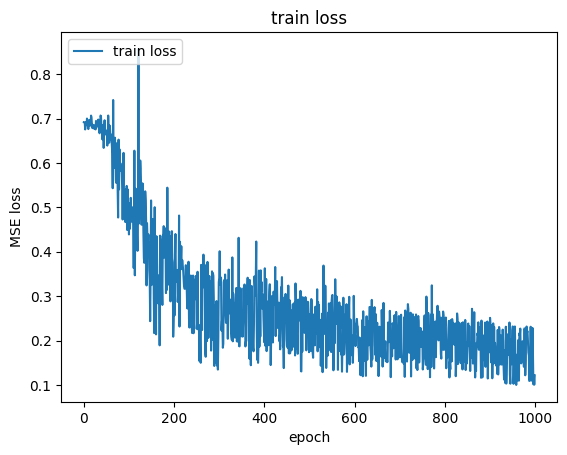

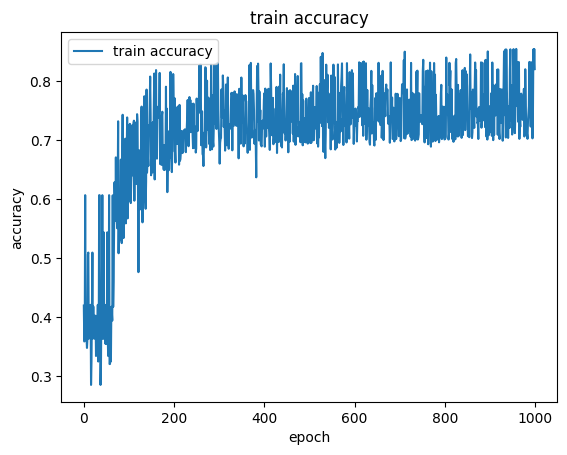

In [9]:
ini = time.time()

continueTrain = False
#continuar treino
if (continueTrain):
    filename = './cells-s512-e200-v1-tf241.h5'
    model = keras.models.load_model(filename);
    versao += 1


# Create a callback that saves the model's weights every 50 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="unet-checkpoint.h5",
        verbose=1, 
        save_weights_only=True,
        save_freq=save_period*train_steps)
    
history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, 
                        validation_steps=valid_steps, epochs=epochs, callbacks=[cp_callback]);
filename = _fileName % (image_size, epochs, versao)

fim = time.time()

print_log("Tempo:", fim-ini)

print_log("Horas:", (fim-ini)/60/60)
print_log(filename)
model.save(filename);
impHistoria(history)

In [10]:
#model = keras.models.load_model(filename);
#model = keras.models.load_model("cells-256-1000-30-v1.h5");
model.evaluate(valid_gen)

1/1 [==============================] - 0s 324ms/step - loss: 0.1797 - acc: 0.7864


[0.17965976893901825, 0.786407470703125]

# PREDICT

1/1 [==============================] - 0s 54ms/step


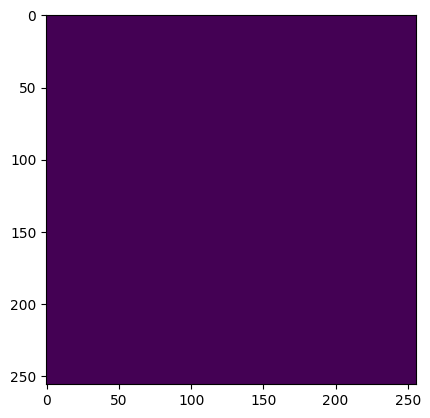

In [57]:
#pred for 512?
p_image, p_mask = train_gen.__getitem__(0); #accessed as normalised bool

result_mask = model.predict(p_image)

pred_mask = tf.argmax(result_mask, axis=-1)
pred_mask = pred_mask[..., tf.newaxis]
pred_mask = pred_mask[0]

#remove a classe 1 que sao as bordas
pred_mask = np.array(pred_mask, dtype='uint8')
pred_mask[pred_mask == 1] = 0

pred_mask = np.array(pred_mask, dtype='uint8')
pred_mask[pred_mask == 2] = 255

plt.imshow(pred_mask)
plt.show()

shape image:  (1, 256, 256, 3) shape mask:  (1, 256, 256, 1)
1/1 [==============================] - 0s 52ms/step
result_mask shape:  (1, 256, 256, 1)


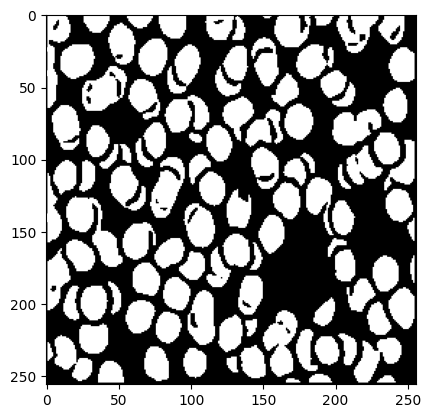

In [72]:

## Dataset for prediction
p_image, p_mask = train_gen.__getitem__(8); #accessed as normalised bool

print("shape image: ", p_image.shape, "shape mask: ", p_mask.shape)

result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);
result_mask = result_mask > 0.50; #float probability to bool conversion

plt.imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
plt.show()




shape image:  (1, 256, 256, 3) shape mask:  (1, 256, 256, 1)
1/1 [==============================] - 0s 58ms/step
result_mask shape:  (1, 256, 256, 1)


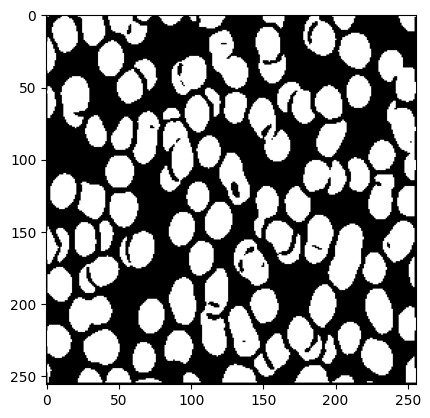

In [13]:

## Dataset for prediction
p_image, p_mask = train_gen.__getitem__(0); #accessed as normalised bool

print("shape image: ", p_image.shape, "shape mask: ", p_mask.shape)

result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);
result_mask = result_mask > 0.50; #float probability to bool conversion

plt.imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
plt.show()




Text(0.5, 1.0, 'Predicted mask')

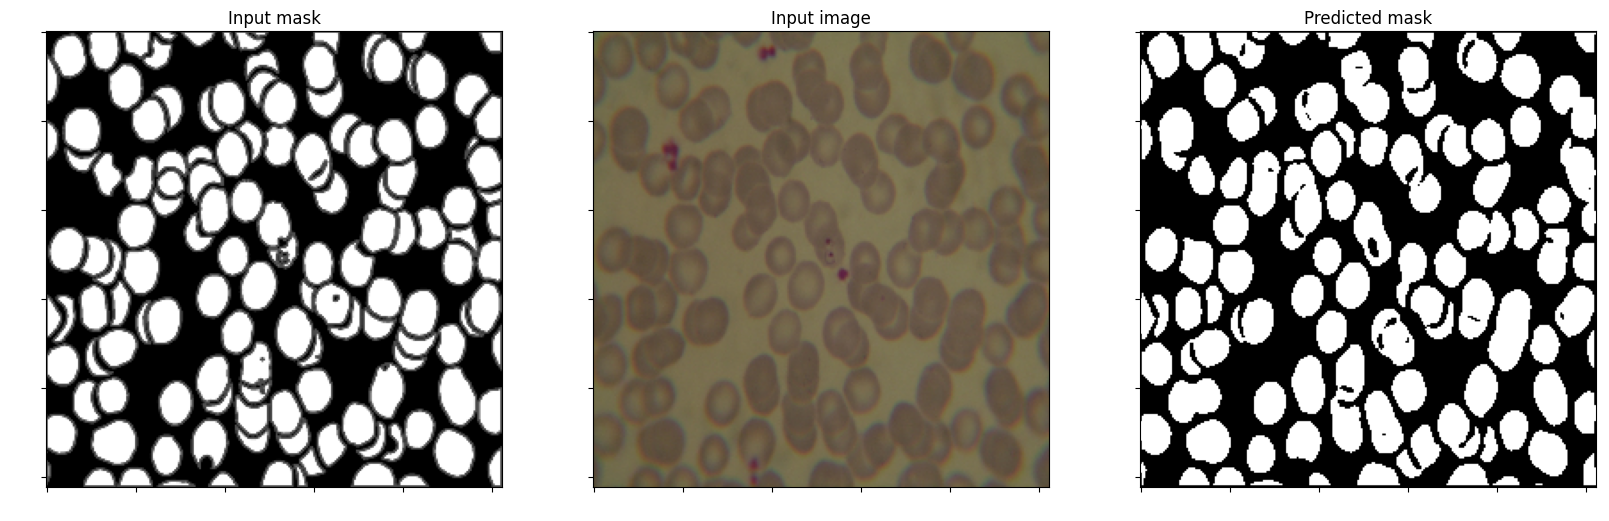

In [14]:


fig1 = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=.4, wspace=.6)
i = 0;
my_plot = fig1.add_subplot(1, 3, 1)
plt.title("Input mask")
plt.xticks(color='w')
plt.yticks(color='w')
my_plot.imshow(np.reshape(p_mask[i]*255, (image_size, image_size)), cmap="gray")

my_plot = fig1.add_subplot(1, 3, 2);
p_image2 = p_image[i][:,:,::-1]
my_plot.imshow(p_image2);
plt.xticks(color='w')
plt.yticks(color='w')
plt.title("Input image")

my_plot = fig1.add_subplot(1, 3, 3)
my_plot.imshow(np.reshape(result_mask[i]*255, (image_size, image_size)), cmap="gray")
plt.xticks(color='w')
plt.yticks(color='w')
plt.title("Predicted mask")

1/1 [==============================] - 0s 54ms/step
result_mask shape:  (1, 256, 256, 1)


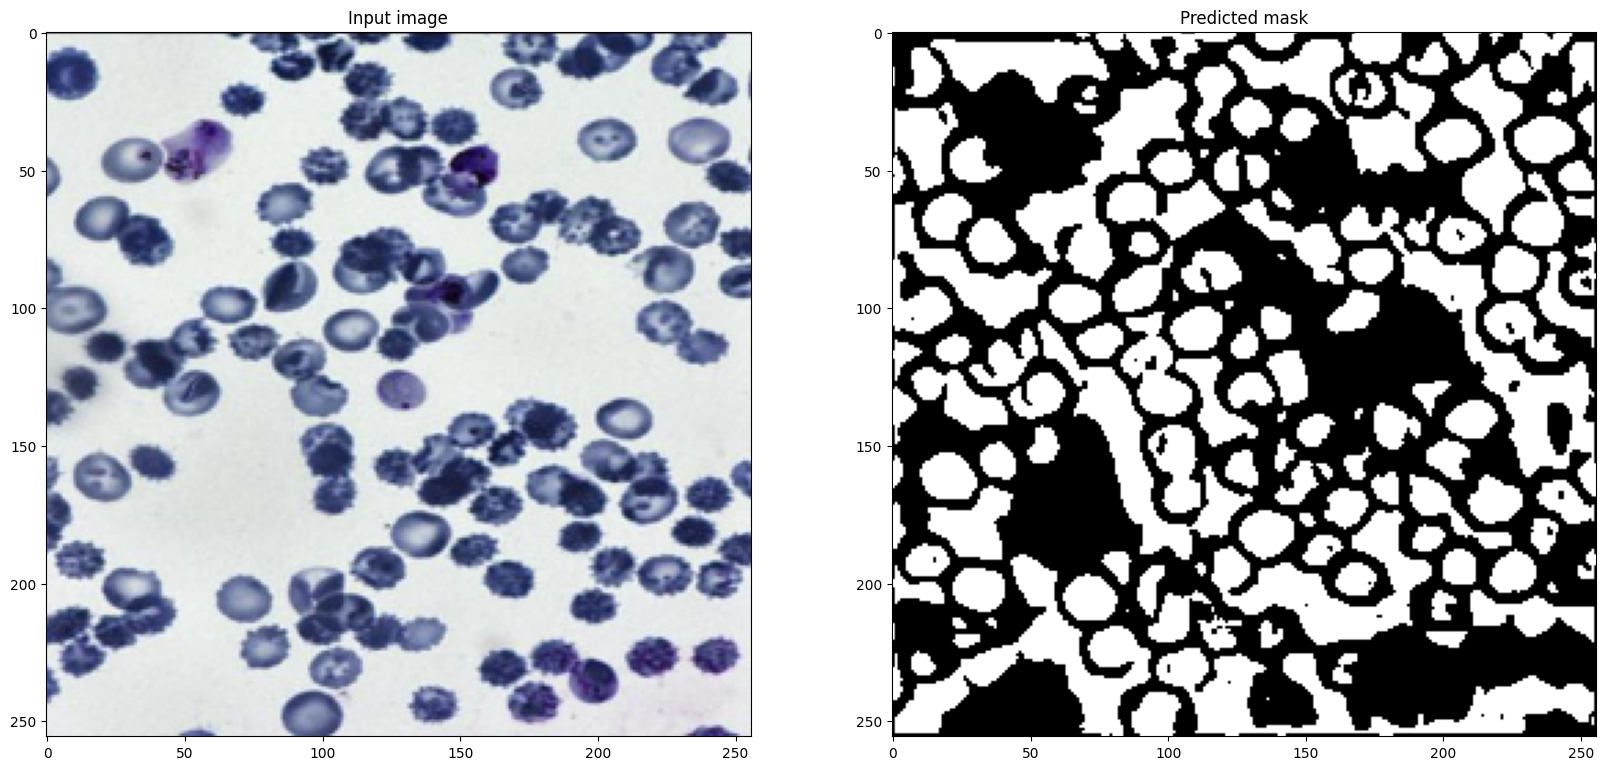

In [15]:
def load_img_norm(image_path, image_size):
        image = cv2.imread(image_path, 1); #reading image to image vaiable
        image = cv2.resize(image, (image_size, image_size));# resizing input image to 128 * 128
        #image normalisation
        image = image / 255.0;
        
        image_r = []
        image_r.append(image);
        image_r = np.array(image_r);
        return image_r;

## Dataset for prediction
#p_image = load_img_norm(gdrive+"/data-1024x1024/images/blood_smear_3.JPG",image_size)
p_image = load_img_norm("../pyAnnotation/malaria_broadinstitute_relabeled-1/train/images/03c8da48-04b9-4520-b674-44a0ecd35688_png.rf.1af68d1c0d903f6e5e13aa4ff2665e6e.jpg",image_size)


result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);

#plt.imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
#plt.show()

result_mask = result_mask > 0.30; #float probability to bool conversion

fig, ax = plt.subplots(ncols=2, figsize=(20,20))

res = p_image[0][:,:,::-1]
ax[0].imshow(res);
ax[0].title.set_text("Input image")

ax[1].imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
ax[1].title.set_text("Predicted mask")

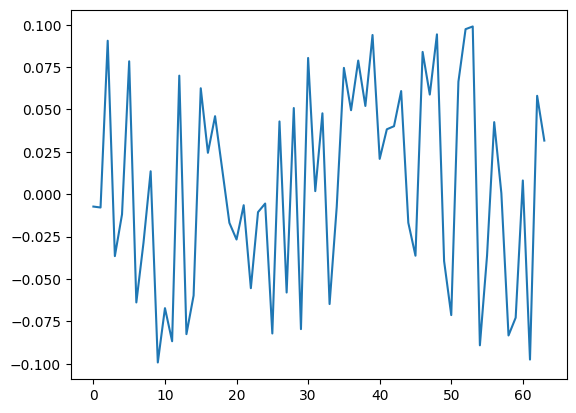

-0.099257566 0.098941386


In [16]:
inputs = keras.layers.Input((128, 128, 3))
c = keras.layers.Conv2D(64, (3,3), padding='same', strides=1, activation="relu")(inputs)
w = c.node.layer.get_weights()
w = w[0][0][0][0]
plt.plot(w)
plt.show()

print (min(w), max(w))

In [17]:
for i in range(10,31):
    image = cv2.imread(gdrive+"/data-1024x1024/masks/blood_smear_%d.png" % i)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    print("blood_smear_%d.png" % i)
    hist /= hist.sum()
    for i in range(256):
        if hist[i][0] > 0:
            print(i,end=",")
    print("")


blood_smear_10.png
0,255,
blood_smear_11.png
0,255,
blood_smear_12.png
0,255,
blood_smear_13.png
0,255,
blood_smear_14.png
0,255,
blood_smear_15.png
0,255,
blood_smear_16.png
0,255,
blood_smear_17.png
0,255,
blood_smear_18.png
0,255,
blood_smear_19.png
0,255,
blood_smear_20.png
0,255,
blood_smear_21.png
0,255,
blood_smear_22.png
0,255,
blood_smear_23.png
0,255,
blood_smear_24.png
0,255,
blood_smear_25.png
0,255,
blood_smear_26.png
0,255,
blood_smear_27.png
0,255,
blood_smear_28.png
0,255,
blood_smear_29.png
0,255,
blood_smear_30.png
0,255,


0
255


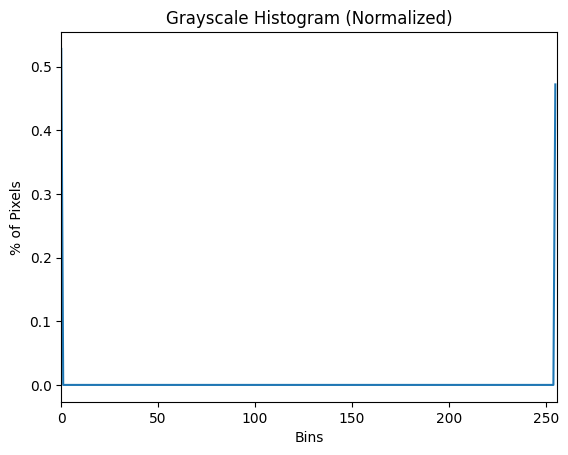

In [18]:
image = cv2.imread(gdrive+"/data-1024x1024/masks/blood_smear_1.png")
hist = cv2.calcHist([image], [0], None, [256], [0, 256])

hist /= hist.sum()
for i in range(256):
    if hist[i][0] > 0:
        print(i)
# plot the normalized histogram
plt.figure()
plt.title("Grayscale Histogram (Normalized)")
plt.xlabel("Bins")
plt.ylabel("% of Pixels")
plt.plot(hist)
plt.xlim([0, 256])
plt.show()